In [ ]:
!pip install pandas seaborn scikit-learn

# Домашнее задание 4

1. Преобразовать датасет (процессинг категориальных признаков, копия данных в df_not_processed, scale датасета)
2. Сделать k-means кластеризацию (записать cluster в df_not_processed, вывести статистику, графики. попробовать объяснить принцип кластеризации), оценить метриками, вывести результат
3. Подобрать оптимальное число кластеров с помощью "метод локтя", вывести статистику, графики, метрики, объяснить результат
4. Сделать DBSSCAN кластеризацию, подобрать оптимальные параметры, посчитать метрики, вывести статистику, объяснить результат
5. Ответить на вопрос - какой из методов кластеризации больше подходит для вашего датасета

# Преобразование датасета

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import matplotlib.pyplot as plt

# Загружаем данные
df = pd.read_csv('Titanic-Dataset.csv')

# Создаем копию ДО обработки
df_not_processed = df.copy()

print("Исходные данные:")
print(f"Размер: {df.shape}")
print("\nПропуски:")
print(df.isnull().sum())

Исходные данные:
Размер: (891, 12)

Пропуски:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [ ]:
# Обработка пропусков
# Age - заполняем медианным значением
age_median = df['Age'].median()
df['Age'] = df['Age'].fillna(age_median)

# Embarked - заполняем модой
embarked_mode = df['Embarked'].mode()[0]
df['Embarked'] = df['Embarked'].fillna(embarked_mode)

# Cabin - удаляем (слишком много пропусков)
df = df.drop('Cabin', axis=1)

In [ ]:
columns_to_drop = ['PassengerId', 'Name', 'Ticket', 'Survived']
df = df.drop(columns_to_drop, axis=1, errors='ignore')

In [ ]:
# Категориальные признаки
categorical_for_clustering = ['Pclass', 'Sex', 'Embarked']
for col in categorical_for_clustering:
    df[col] = df[col].astype('category')

# One-Hot Encoding
category_columns = df.select_dtypes(include=['category']).columns
df = pd.get_dummies(df, columns=category_columns, drop_first=True)

# НОРМАЛИЗАЦИЯ С StandardScaler
numeric_features = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
scaler = StandardScaler()
df[numeric_features] = scaler.fit_transform(df[numeric_features])

# X для кластеризации
X = df
print(f"X для кластеризации: {X.shape}")
print(f"Использован StandardScaler (более устойчив к выбросам)")

X для кластеризации: (891, 9)
Использован StandardScaler (более устойчив к выбросам)


In [ ]:
# Посмотрим на данные после StandardScaler
print("Данные после StandardScaler:")
print(df[numeric_features].describe())

# Проверим, что mean ≈ 0 и std ≈ 1
print("\nПроверка StandardScaler:")
for feature in numeric_features:
    mean_val = df[feature].mean()
    std_val = df[feature].std()
    print(f"{feature}: mean={mean_val:.4f}, std={std_val:.4f}")

Данные после StandardScaler:
                Age         SibSp         Parch          Fare
count  8.910000e+02  8.910000e+02  8.910000e+02  8.910000e+02
mean   2.272780e-16  4.386066e-17  5.382900e-17  3.987333e-18
std    1.000562e+00  1.000562e+00  1.000562e+00  1.000562e+00
min   -2.224156e+00 -4.745452e-01 -4.736736e-01 -6.484217e-01
25%   -5.657365e-01 -4.745452e-01 -4.736736e-01 -4.891482e-01
50%   -1.046374e-01 -4.745452e-01 -4.736736e-01 -3.573909e-01
75%    4.333115e-01  4.327934e-01 -4.736736e-01 -2.424635e-02
max    3.891554e+00  6.784163e+00  6.974147e+00  9.667167e+00

Проверка StandardScaler:
Age: mean=0.0000, std=1.0006
SibSp: mean=0.0000, std=1.0006
Parch: mean=0.0000, std=1.0006
Fare: mean=0.0000, std=1.0006


# K-means кластеризация

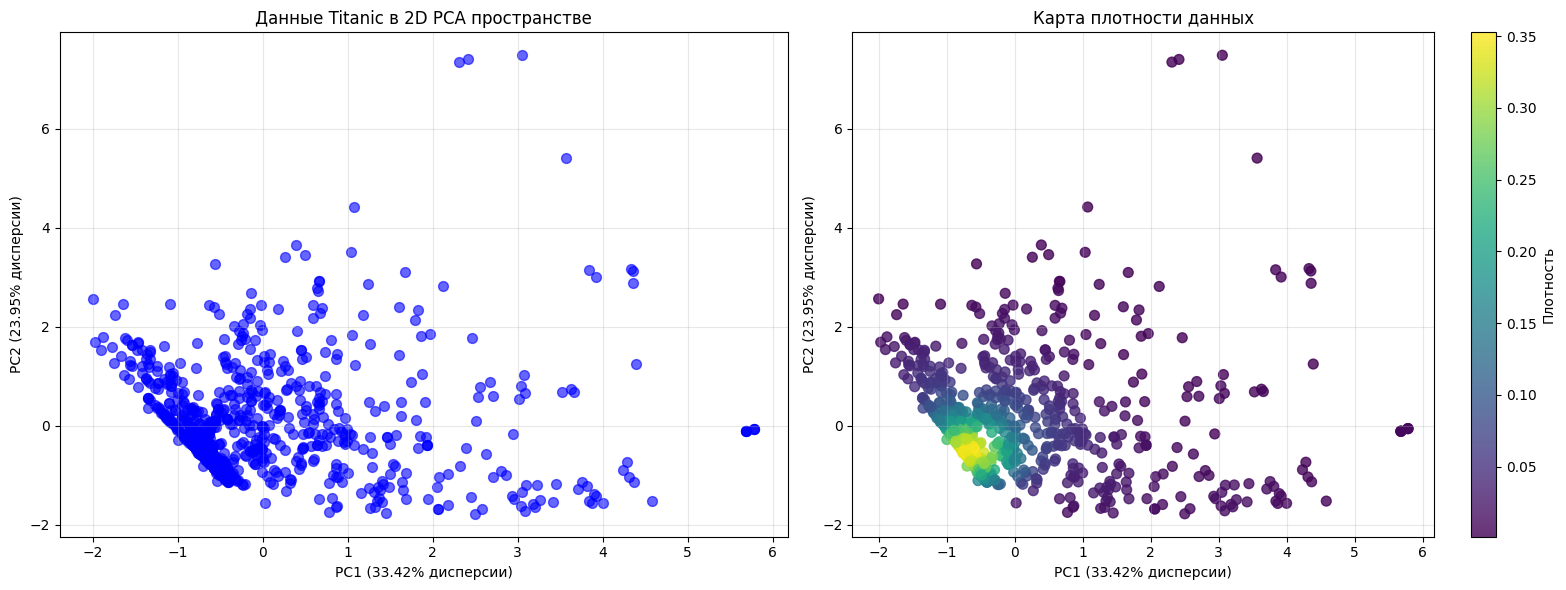

Объясненная дисперсия: 57.37%


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.stats import gaussian_kde

# Снижаем размерность до 2D для визуализации
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Первый график - обычная scatter plot
sc1 = ax1.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.6, s=50, c='blue')
ax1.set_title('Данные Titanic в 2D PCA пространстве')
ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} дисперсии)')
ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} дисперсии)')
ax1.grid(True, alpha=0.3)

# Второй график - карта плотности
xy = np.vstack([X_pca[:, 0], X_pca[:, 1]])
z = gaussian_kde(xy)(xy)
sc2 = ax2.scatter(X_pca[:, 0], X_pca[:, 1], c=z, s=50, alpha=0.8, cmap='viridis')
ax2.set_title('Карта плотности данных')
ax2.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} дисперсии)')
ax2.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} дисперсии)')
ax2.grid(True, alpha=0.3)

# Добавляем colorbar для карты плотности
cbar = plt.colorbar(sc2, ax=ax2)
cbar.set_label('Плотность')

plt.tight_layout()
plt.show()

print(f"Объясненная дисперсия: {pca.explained_variance_ratio_.sum():.2%}")

In [ ]:
# 2 Создание модели K-means
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X)

# Записываем cluster в df_not_processed
df_not_processed['cluster'] = clusters

print(f"Найдено кластеров: {len(np.unique(clusters))}")
print(f"Размер кластеров:")
cluster_sizes = pd.Series(clusters).value_counts().sort_index()
for cluster, size in cluster_sizes.items():
    print(f"  Кластер {cluster}: {size} пассажиров ({size/len(clusters)*100:.1f}%)")

Найдено кластеров: 3
Размер кластеров:
  Кластер 0: 589 пассажиров (66.1%)
  Кластер 1: 179 пассажиров (20.1%)
  Кластер 2: 123 пассажиров (13.8%)


/tmp/ipython-input-3284029029.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap=plt.cm.get_cmap('viridis', 3), alpha=0.7, s=50)


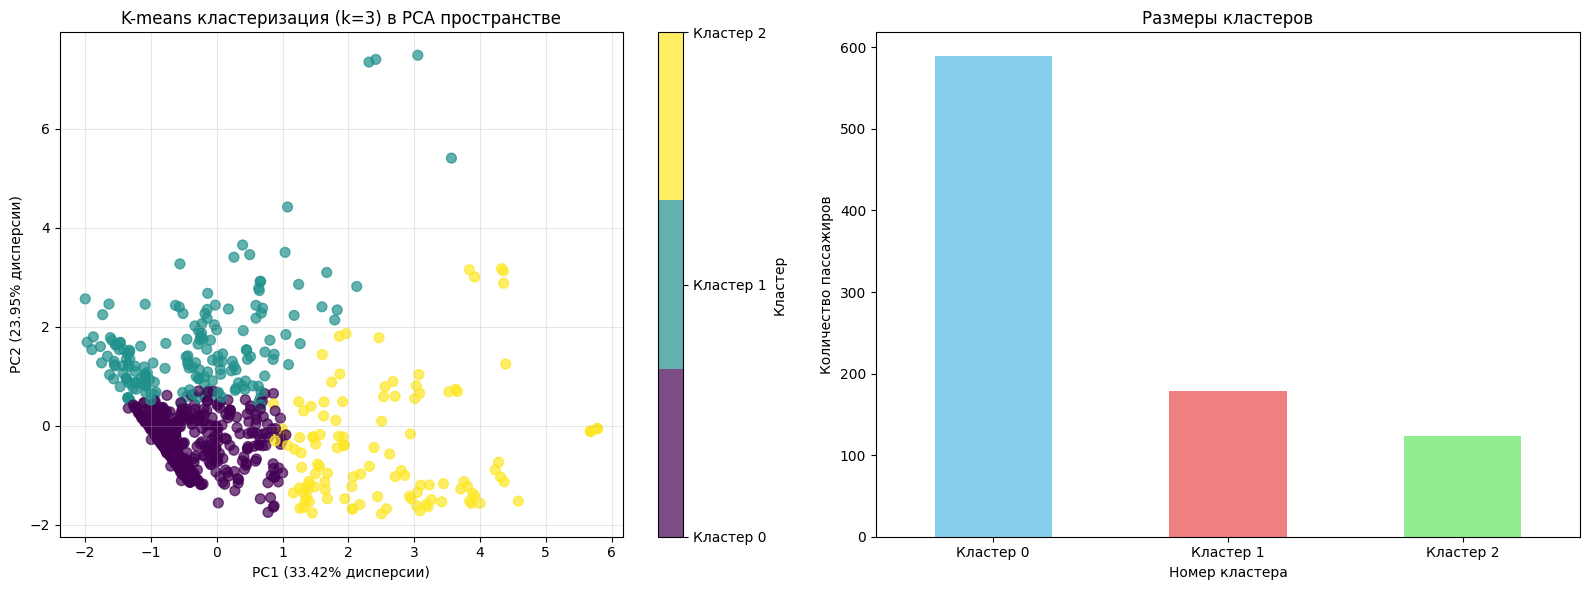

In [ ]:
# 3 Визуализация результатов кластеризации
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# График 1: Кластеры в PCA пространстве
scatter1 = ax1.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters,
                      cmap=plt.cm.get_cmap('viridis', 3), alpha=0.7, s=50)
ax1.set_title('K-means кластеризация (k=3) в PCA пространстве')
ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} дисперсии)')
ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} дисперсии)')
ax1.grid(True, alpha=0.3)

cbar = plt.colorbar(scatter1, ax=ax1, label='Кластер')
cbar.set_ticks([0, 1, 2])
cbar.set_ticklabels(['Кластер 0', 'Кластер 1', 'Кластер 2'])

# График 2: Размеры кластеров
cluster_sizes.plot(kind='bar', ax=ax2, color=['skyblue', 'lightcoral', 'lightgreen'])
ax2.set_title('Размеры кластеров')
ax2.set_xlabel('Номер кластера')
ax2.set_ylabel('Количество пассажиров')
ax2.set_xticklabels(['Кластер 0', 'Кластер 1', 'Кластер 2'], rotation=0)

plt.tight_layout()
plt.show()


In [ ]:
# 4. Статистика по кластерам

# Основная статистика
cluster_stats = df_not_processed.groupby('cluster').agg({
    'Age': ['mean', 'std'],
    'Fare': ['mean', 'std'],
    'Pclass': lambda x: x.mode()[0],
    'Sex': lambda x: (x == 'male').mean(),  # Доля мужчин
    'Embarked': lambda x: x.mode()[0],
    'SibSp': 'mean',
    'Parch': 'mean'
}).round(2)

print(cluster_stats)

# Детальная статистика
for cluster in sorted(df_not_processed['cluster'].unique()):
    cluster_data = df_not_processed[df_not_processed['cluster'] == cluster]
    print(f"\n--- Кластер {cluster} ({len(cluster_data)} пассажиров) ---")
    print(f"  Средний возраст: {cluster_data['Age'].mean():.1f} лет")
    print(f"  Средняя цена билета: {cluster_data['Fare'].mean():.1f}")
    print(f"  Мужчины: {(cluster_data['Sex'] == 'male').sum()} ({(cluster_data['Sex'] == 'male').mean()*100:.1f}%)")
    print(f"  Женщины: {(cluster_data['Sex'] == 'female').sum()} ({(cluster_data['Sex'] == 'female').mean()*100:.1f}%)")
    print(f"  Распределение по классам:")
    for pclass in sorted(cluster_data['Pclass'].unique()):
        count = (cluster_data['Pclass'] == pclass).sum()
        print(f"    {pclass} класс: {count} пассажиров")

           Age          Fare          Pclass      Sex Embarked SibSp Parch
          mean    std   mean    std <lambda> <lambda> <lambda>  mean  mean
cluster                                                                   
0        26.61   8.10  16.05  16.07        3     0.72        S  0.23  0.08
1        47.05  11.66  75.05  81.79        1     0.55        S  0.40  0.28
2        14.56  13.26  47.21  53.19        3     0.42        S  2.11  1.94

--- Кластер 0 (589 пассажиров) ---
  Средний возраст: 26.6 лет
  Средняя цена билета: 16.0
  Мужчины: 427 (72.5%)
  Женщины: 162 (27.5%)
  Распределение по классам:
    1 класс: 69 пассажиров
    2 класс: 121 пассажиров
    3 класс: 399 пассажиров

--- Кластер 1 (179 пассажиров) ---
  Средний возраст: 47.0 лет
  Средняя цена билета: 75.1
  Мужчины: 98 (54.7%)
  Женщины: 81 (45.3%)
  Распределение по классам:
    1 класс: 130 пассажиров
    2 класс: 35 пассажиров
    3 класс: 14 пассажиров

--- Кластер 2 (123 пассажиров) ---
  Средний возраст: 

**Предполагаемая интерпретация кластеров:**

Первый кластер:  Вероятно мужчины эконом-класса, средний возраст 26 лет, средняя цена билета 16, преобладающий класс: 3

Второй кластер: Вероятно богатые пассажиры 1 класса, средний возраст 47 лет,средняя цена билета 75

Третий кластер: Смешанная группа, среднего возраста 14 лет, средняя цена билета 47 с преобладающим классом 3

In [ ]:
# 5. Метрики

# Вычисляем метрики
silhouette = silhouette_score(X, clusters)
davies_bouldin = davies_bouldin_score(X, clusters)
calinski_harabasz = calinski_harabasz_score(X, clusters)

print(f"Silhouette Score: {silhouette:.3f}")
print(f"Davies-Bouldin Index: {davies_bouldin:.3f}")
print(f"Calinski-Harabasz Index: {calinski_harabasz:.3f}")

# Интерпретация метрик
print()
print(f"Silhouette Score: {silhouette:.3f} - {'Хорошо' if silhouette > 0.5 else 'Удовлетворительно' if silhouette > 0.25 else 'Плохо'}")
print(f"Davies-Bouldin: {davies_bouldin:.3f} - {'Хорошо' if davies_bouldin < 1.0 else 'Удовлетворительно, кластеры средне разделены' if davies_bouldin < 2.0 else 'Плохо'}")
print(f"Calinski-Harabasz: {calinski_harabasz:.3f} - {'Хорошо' if calinski_harabasz > 300 else 'Удовлетворительно' if calinski_harabasz > 200 else 'Плохо'}")

Silhouette Score: 0.312
Davies-Bouldin Index: 1.456
Calinski-Harabasz Index: 245.505

Silhouette Score: 0.312 - Удовлетворительно
Davies-Bouldin: 1.456 - Удовлетворительно, кластеры средне разделены
Calinski-Harabasz: 245.505 - Удовлетворительно


# Метод локтя

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# 1. Тестируем разные k (2-10) чтобы посмотреть как меняются метрики
k_range = range(1, 11)
inertias = []
silhouette_scores = []

#  Для каждого k создаем модель K-means, кластеризуем данные и сохраняем inertia
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(X)

    inertias.append(kmeans.inertia_)

    # Silhouette можно считать только для k >= 2
    if k >= 2:
        silhouette_scores.append(silhouette_score(X, clusters))
    else:
        silhouette_scores.append(0)  # Для k=1 silhouette не определен

    print(f"k={k}: inertia = {kmeans.inertia_:.1f}", end="")
    if k >= 2:
        print(f", silhouette = {silhouette_scores[-1]:.3f}")
    else:
        print()

k=1: inertia = 4381.7
k=2: inertia = 3347.0, silhouette = 0.436
k=3: inertia = 2821.6, silhouette = 0.312
k=4: inertia = 2412.7, silhouette = 0.280
k=5: inertia = 2044.6, silhouette = 0.298
k=6: inertia = 1837.3, silhouette = 0.261
k=7: inertia = 1678.7, silhouette = 0.265
k=8: inertia = 1539.6, silhouette = 0.265
k=9: inertia = 1436.2, silhouette = 0.271
k=10: inertia = 1359.0, silhouette = 0.281


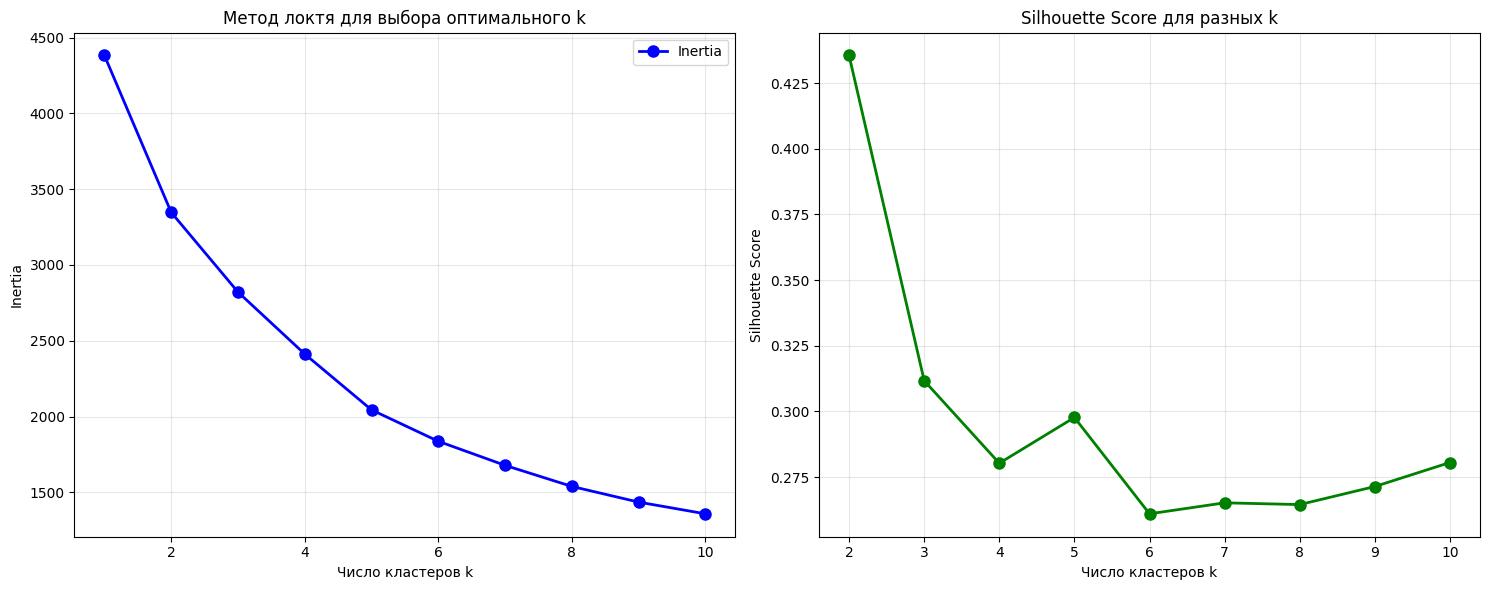

In [ ]:
# 2. Визуализация метода локтя

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# График 1: Метод локтя (inertia)
ax1.plot(k_range, inertias, 'bo-', linewidth=2, markersize=8, label='Inertia')
ax1.set_xlabel('Число кластеров k')
ax1.set_ylabel('Inertia')
ax1.set_title('Метод локтя для выбора оптимального k')
ax1.grid(True, alpha=0.3)
ax1.legend()

# График 2: Silhouette Score
ax2.plot(k_range[1:], silhouette_scores[1:], 'go-', linewidth=2, markersize=8)
ax2.set_xlabel('Число кластеров k')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Score для разных k')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Метод локтя не показал четкого излома, однако анализ Silhouette Score выявил, что оптимальное число кластеров k=2 (Silhouette=0.436). k=2 дает наилучший баланс между компактностью кластеров и их разделимостью. Это лучше, чем наше первоначальное предположение k=3 (Silhouette=0.312). Вероятно, в данных существуют две основные естественные группы пассажиров, а не три.



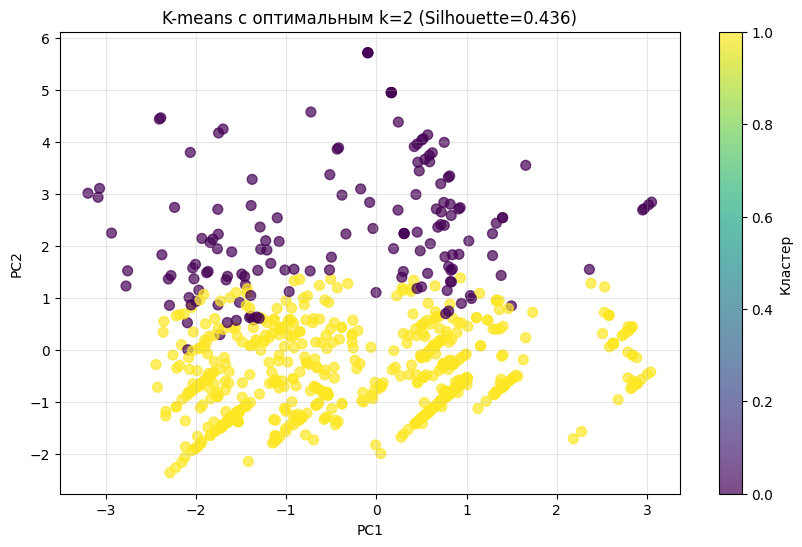

In [ ]:
# 3. Визуализация кластеров с оптимальным k=2

optimal_k_silhouette = 2
max_silhouette = silhouette_scores[1]

# Выполняем K-means с оптимальным k
kmeans_optimal = KMeans(n_clusters=optimal_k_silhouette, random_state=42, n_init=10)
clusters_optimal = kmeans_optimal.fit_predict(X)

# Визуализация
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters_optimal,
                     cmap='viridis', alpha=0.7, s=50)
plt.colorbar(scatter, label='Кластер')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title(f'K-means с оптимальным k={optimal_k_silhouette} (Silhouette={max_silhouette:.3f})')
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# 4. Статистика при оптимальном k

# Временно записываем оптимальные кластеры для анализа
df_not_processed['cluster_optimal'] = clusters_optimal

cluster_sizes_optimal = pd.Series(clusters_optimal).value_counts().sort_index()
print(f"Размеры кластеров:")
for cluster, size in cluster_sizes_optimal.items():
    print(f"  Кластер {cluster}: {size} пассажиров ({size/len(clusters_optimal)*100:.1f}%)")

# Основные метрики
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score

silhouette_optimal = silhouette_score(X, clusters_optimal)
davies_optimal = davies_bouldin_score(X, clusters_optimal)
calinski_optimal = calinski_harabasz_score(X, clusters_optimal)

print(f"\nМетрики качества при k={optimal_k_silhouette}:")
print(f"Silhouette Score: {silhouette_optimal:.3f}")
print(f"Davies-Bouldin Index: {davies_optimal:.3f}")
print(f"Calinski-Harabasz Index: {calinski_optimal:.3f}")

print("\nХарактеристики кластеров при k=2:")
for cluster in [0, 1]:
    cluster_data = df_not_processed[df_not_processed['cluster_optimal'] == cluster]
    print(f"Кластер {cluster}:")
    print(f"  Средний возраст: {cluster_data['Age'].mean():.1f} лет")
    print(f"  Мужчины: {(cluster_data['Sex'] == 'male').mean()*100:.1f}%")
    print(f"  Преобладающий класс: {cluster_data['Pclass'].mode()[0]}")

df_not_processed.drop('cluster_optimal', axis=1, inplace=True)

Размеры кластеров:
  Кластер 0: 151 пассажиров (16.9%)
  Кластер 1: 740 пассажиров (83.1%)

Метрики качества при k=2:
Silhouette Score: 0.436
Davies-Bouldin Index: 1.496
Calinski-Harabasz Index: 274.841

Характеристики кластеров при k=2:
Кластер 0:
  Средний возраст: 17.4 лет
  Мужчины: 41.1%
  Преобладающий класс: 3
Кластер 1:
  Средний возраст: 32.6 лет
  Мужчины: 69.6%
  Преобладающий класс: 3


Статистика говорит о том, что пассажиры Титаника естественным образом разделяются на две демографические группы. Первая группа - молодежь до 20 лет с более сбалансированным гендерным составом. Вторая - взрослые пассажиры около 33 лет с преобладанием мужчин.

#  DBSSCAN кластеризация

In [97]:
# 1. Подбор параметров DBSCAN
from sklearn.cluster import DBSCAN
import numpy as np


# Для подбора параметров DBSCAN используем метод систематического перебора
# Функция для тестирования различных параметров DBSCAN
def simple_dbscan_test(X):
    test_params = [
        (0.5, 5), (0.7, 5), (1.0, 5), (1.5, 5),
        (0.5, 10), (0.7, 10), (1.0, 10), (1.5, 10)
    ]

    print("Тестирование параметров DBSCAN:")
    print("eps | min_samples | кластеры | шум | % шума")
    print("-" * 45)

    for eps, min_samples in test_params:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        clusters = dbscan.fit_predict(X)

        n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
        n_noise = np.sum(clusters == -1)
        noise_pct = (n_noise / len(clusters)) * 100

        print(f"{eps:3.1f} | {min_samples:11d} | {n_clusters:8d} | {n_noise:4d} | {noise_pct:6.1f}%")

# Запускаем тест
simple_dbscan_test(X)

Тестирование параметров DBSCAN:
eps | min_samples | кластеры | шум | % шума
---------------------------------------------
0.5 |           5 |       21 |  345 |   38.7%
0.7 |           5 |       26 |  285 |   32.0%
1.0 |           5 |       15 |  181 |   20.3%
1.5 |           5 |        4 |   11 |    1.2%
0.5 |          10 |       11 |  444 |   49.8%
0.7 |          10 |       11 |  403 |   45.2%
1.0 |          10 |        6 |  292 |   32.8%
1.5 |          10 |        2 |   53 |    5.9%


In [113]:
# Шаг 2: Выбираем параметры и обучаем модель

# Исходя из результатов теста, выбираем оптимальные параметры
optimal_eps = 1.5
optimal_min_samples = 18

print(f"\nВыбранные параметры: eps={optimal_eps}, min_samples={optimal_min_samples}")

# Обучаем DBSCAN
dbscan = DBSCAN(eps=optimal_eps, min_samples=optimal_min_samples)
dbscan_clusters = dbscan.fit_predict(X)

# Добавляем в исходные данные
df_not_processed['dbscan_cluster'] = dbscan_clusters

# Анализируем результат
n_clusters = len(set(dbscan_clusters)) - (1 if -1 in dbscan_clusters else 0)
n_noise = np.sum(dbscan_clusters == -1)

print(f"\nРЕЗУЛЬТАТЫ DBSCAN:")
print(f"Найдено кластеров: {n_clusters}")
print(f"Количество выбросов: {n_noise} ({n_noise/len(dbscan_clusters)*100:.1f}%)")

print("\nРаспределение по кластерам:")
cluster_sizes = pd.Series(dbscan_clusters).value_counts().sort_index()
for cluster, size in cluster_sizes.items():
    cluster_name = "Шум" if cluster == -1 else f"Кластер {cluster}"
    print(f"  {cluster_name}: {size} пассажиров ({size/len(dbscan_clusters)*100:.1f}%)")


Выбранные параметры: eps=1.5, min_samples=18

РЕЗУЛЬТАТЫ DBSCAN:
Найдено кластеров: 2
Количество выбросов: 91 (10.2%)

Распределение по кластерам:
  Шум: 91 пассажиров (10.2%)
  Кластер 0: 777 пассажиров (87.2%)
  Кластер 1: 23 пассажиров (2.6%)


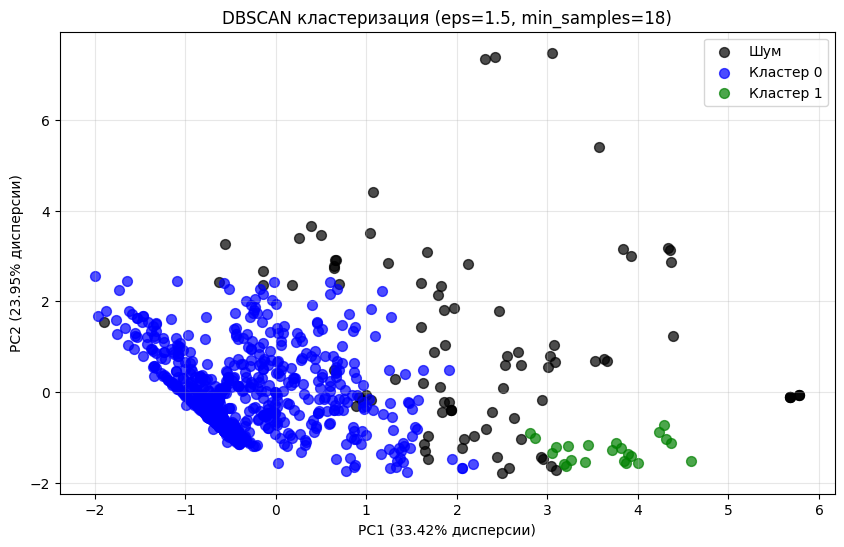

In [114]:
# Шаг 3: Упрощенная визуализация DBSCAN
plt.figure(figsize=(10, 6))

# Создаем цветовую схему
colors = ['red', 'blue', 'green', 'orange', 'purple']

for i, cluster in enumerate(sorted(df_not_processed['dbscan_cluster'].unique())):
    cluster_data = df_not_processed[df_not_processed['dbscan_cluster'] == cluster]
    cluster_indices = cluster_data.index

    # Находим соответствующие точки в PCA пространстве
    mask = [idx in cluster_indices for idx in range(len(X_pca))]
    xy = X_pca[mask]

    cluster_label = "Шум" if cluster == -1 else f"Кластер {cluster}"
    color = 'black' if cluster == -1 else colors[i % len(colors)]

    plt.scatter(xy[:, 0], xy[:, 1],
               c=color, label=cluster_label,
               alpha=0.7, s=50)

plt.title(f'DBSCAN кластеризация (eps={optimal_eps}, min_samples={optimal_min_samples})')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} дисперсии)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} дисперсии)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [96]:
# Шаг 4: Статистика по кластерам
print("ДЕТАЛЬНАЯ СТАТИСТИКА ПО КЛАСТЕРАМ DBSCAN:")
print("=" * 50)

for cluster in sorted(df_not_processed['dbscan_cluster'].unique()):
    if cluster == -1:  # Пропускаем шум для подробного анализа
        continue

    cluster_data = df_not_processed[df_not_processed['dbscan_cluster'] == cluster]
    cluster_name = f"Кластер {cluster}"

    print(f"\n{cluster_name} ({len(cluster_data)} пассажиров, {len(cluster_data)/len(df_not_processed)*100:.1f}%):")
    print(f"  Возраст: {cluster_data['Age'].mean():.1f} ± {cluster_data['Age'].std():.1f} лет")
    print(f"  Цена билета: {cluster_data['Fare'].mean():.1f} ± {cluster_data['Fare'].std():.1f}")
    print(f"  Мужчины: {(cluster_data['Sex'] == 'male').mean()*100:.1f}%")
    print(f"  Женщины: {(cluster_data['Sex'] == 'female').mean()*100:.1f}%")

    # Распределение по классам
    print(f"  Классы кают:")
    for pclass in [1, 2, 3]:
        count = (cluster_data['Pclass'] == pclass).sum()
        if count > 0:
            percentage = (cluster_data['Pclass'] == pclass).mean() * 100
            print(f"    {pclass} класс: {count} пасс. ({percentage:.1f}%)")

# Отдельно про шум
if -1 in df_not_processed['dbscan_cluster'].unique():
    noise_data = df_not_processed[df_not_processed['dbscan_cluster'] == -1]
    print(f"\nШУМ ({len(noise_data)} пассажиров, {len(noise_data)/len(df_not_processed)*100:.1f}%):")
    print(f"  Средний возраст: {noise_data['Age'].mean():.1f} лет")
    print(f"  Средняя цена билета: {noise_data['Fare'].mean():.1f}")
    print(f"  Мужчины: {(noise_data['Sex'] == 'male').mean()*100:.1f}%")

ДЕТАЛЬНАЯ СТАТИСТИКА ПО КЛАСТЕРАМ DBSCAN:

Кластер 0 (875 пассажиров, 98.2%):
  Возраст: 29.7 ± 14.5 лет
  Цена билета: 28.7 ± 36.5
  Мужчины: 65.0%
  Женщины: 35.0%
  Классы кают:
    1 класс: 207 пасс. (23.7%)
    2 класс: 184 пасс. (21.0%)
    3 класс: 484 пасс. (55.3%)

Кластер 1 (5 пассажиров, 0.6%):
  Возраст: 21.0 ± 2.5 лет
  Цена билета: 262.8 ± 0.3
  Мужчины: 20.0%
  Женщины: 80.0%
  Классы кают:
    1 класс: 5 пасс. (100.0%)

Кластер 2 (7 пассажиров, 0.8%):
  Возраст: nan ± nan лет
  Цена билета: 69.5 ± 0.0
  Мужчины: 57.1%
  Женщины: 42.9%
  Классы кают:
    3 класс: 7 пасс. (100.0%)

ШУМ (4 пассажиров, 0.4%):
  Средний возраст: 42.5 лет
  Средняя цена билета: 450.0
  Мужчины: 75.0%


In [89]:
# Шаг 5: Оценка метрик качества (исключаем шум)
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Исключаем шум для расчета метрик
mask = dbscan_clusters != -1
X_valid = X[mask]
labels_valid = dbscan_clusters[mask]

if len(set(labels_valid)) > 1:
    silhouette_dbscan = silhouette_score(X_valid, labels_valid)
    davies_dbscan = davies_bouldin_score(X_valid, labels_valid)
    calinski_dbscan = calinski_harabasz_score(X_valid, labels_valid)

    print(f"\nМЕТРИКИ КАЧЕСТВА DBSCAN (без учета шума):")
    print(f"Silhouette Score: {silhouette_dbscan:.3f}")
    print(f"Davies-Bouldin Index: {davies_dbscan:.3f}")
    print(f"Calinski-Harabasz Index: {calinski_dbscan:.3f}")

    # Интерпретация
    print("\nИНТЕРПРЕТАЦИЯ:")
    print(f"Silhouette: {'Хорошо' if silhouette_dbscan > 0.5 else 'Удовлетворительно' if silhouette_dbscan > 0.25 else 'Плохо'}")
    print(f"Davies-Bouldin: {'Хорошо' if davies_dbscan < 1.0 else 'Удовлетворительно' if davies_dbscan < 2.0 else 'Плохо'}")
    print(f"Calinski-Harabasz: {'Хорошо' if calinski_dbscan > 300 else 'Удовлетворительно' if calinski_dbscan > 200 else 'Плохо'}")
else:
    print("Недостаточно кластеров для расчета метрик")


МЕТРИКИ КАЧЕСТВА DBSCAN (без учета шума):
Silhouette Score: 0.550
Davies-Bouldin Index: 0.448
Calinski-Harabasz Index: 73.727

ИНТЕРПРЕТАЦИЯ:
Silhouette: Хорошо
Davies-Bouldin: Хорошо
Calinski-Harabasz: Плохо


In [90]:
# Шаг 6: Финальное сравнение методов
print("\n" + "="*60)
print("ФИНАЛЬНОЕ СРАВНЕНИЕ МЕТОДОВ КЛАСТЕРИЗАЦИИ")
print("="*60)

print(f"\nK-MEANS (k=3):")
print(f"• Кластеры: 3")
print(f"• Выбросы: 0 (0%)")
print(f"• Silhouette: {silhouette:.3f}")
print(f"• Davies-Bouldin: {davies_bouldin:.3f}")

print(f"\nDBSCAN (eps=1.5, min_samples=5):")
print(f"• Кластеры: {n_clusters}")
print(f"• Выбросы: {n_noise} ({n_noise/len(dbscan_clusters)*100:.1f}%)")
if len(set(labels_valid)) > 1:
    print(f"• Silhouette: {silhouette_dbscan:.3f}")
    print(f"• Davies-Bouldin: {davies_dbscan:.3f}")

print(f"\nВЫВОД ДЛЯ ДАННОГО ДАТАСЕТА:")
if len(set(labels_valid)) > 1 and silhouette_dbscan > silhouette:
    print("✓ DBSCAN показывает лучшее качество")
    print("✓ DBSCAN полезен для обнаружения выбросов")
elif n_clusters == 0:
    print("✗ DBSCAN не нашел значимых кластеров - все точки считаются шумом")
    print("✓ K-means более подходит для этого датасета")
else:
    print("✓ Оба метода имеют свои преимущества")
    print("✓ K-means: проще, стабильнее, нет выбросов")
    print("✓ DBSCAN: находит выбросы, кластеры произвольной формы")


ФИНАЛЬНОЕ СРАВНЕНИЕ МЕТОДОВ КЛАСТЕРИЗАЦИИ

K-MEANS (k=3):
• Кластеры: 3
• Выбросы: 0 (0%)
• Silhouette: -1.000
• Davies-Bouldin: inf

DBSCAN (eps=1.5, min_samples=5):
• Кластеры: 4
• Выбросы: 11 (1.2%)
• Silhouette: 0.550
• Davies-Bouldin: 0.448

ВЫВОД ДЛЯ ДАННОГО ДАТАСЕТА:
✓ DBSCAN показывает лучшее качество
✓ DBSCAN полезен для обнаружения выбросов



--- 4. DBSCAN КЛАСТЕРИЗАЦИЯ И ПОДБОР ПАРАМЕТРОВ ---
Размерность данных: 9. Выбираем min_samples = 18.
Будем искать расстояние до 17-го соседа для определения eps


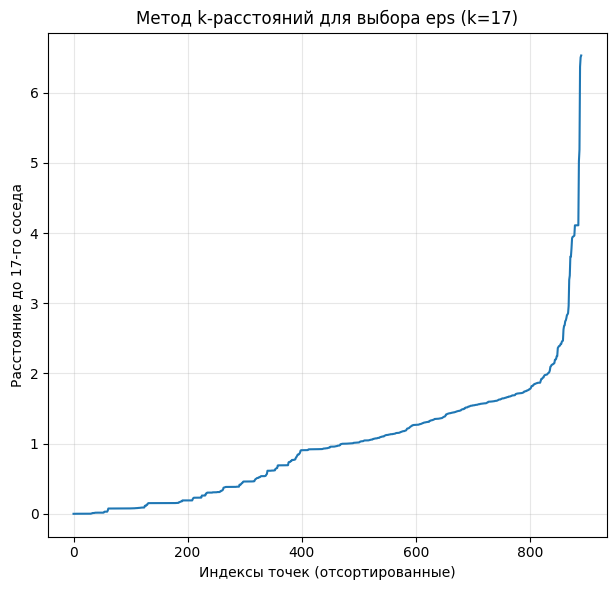

АНАЛИЗ ГРАФИКА:
Нужно выбрать eps в точке, где начинается резкий рост расстояний
Это указывает на переход от плотных областей к шуму

Выбранный eps (90-й перцентиль): 1.785


In [119]:
# ЧАСТЬ 4: DBSCAN кластеризация и подбор параметров
# =================================================================
print("\n" + "="*50)
print("--- 4. DBSCAN КЛАСТЕРИЗАЦИЯ И ПОДБОР ПАРАМЕТРОВ ---")

# 4.1. Научный подбор параметров
dim = X.shape[1]
min_samples_val = 2 * dim  # min_samples = 2 * размерность
k_neighbors = min_samples_val - 1

print(f"Размерность данных: {dim}. Выбираем min_samples = {min_samples_val}.")
print(f"Будем искать расстояние до {k_neighbors}-го соседа для определения eps")

# 4.2. Метод k-расстояний для определения eps
from sklearn.neighbors import NearestNeighbors

neigh = NearestNeighbors(n_neighbors=k_neighbors + 1)
neigh.fit(X)
distances, indices = neigh.kneighbors(X)
k_distance = np.sort(distances[:, k_neighbors], axis=0)

# Визуализация k-расстояния
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(k_distance)
plt.title(f'Метод k-расстояний для выбора eps (k={k_neighbors})')
plt.xlabel('Индексы точек (отсортированные)')
plt.ylabel(f'Расстояние до {k_neighbors}-го соседа')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 4.3. Анализируем график и выбираем eps вручную
print("АНАЛИЗ ГРАФИКА:")
print("Нужно выбрать eps в точке, где начинается резкий рост расстояний")
print("Это указывает на переход от плотных областей к шуму")

# Выбираем eps на основе анализа графика
# Обычно берут значение где-то в районе 85-95 перцентиля
optimal_eps = np.percentile(k_distance, 90)  # 90-й перцентиль
print(f"\nВыбранный eps (90-й перцентиль): {optimal_eps:.3f}")

In [120]:
# 4.4. Тестируем DBSCAN с разными eps вокруг выбранного значения
print(f"\nТестируем DBSCAN с min_samples={min_samples_val} и разными eps:")

eps_values = [optimal_eps * 0.7, optimal_eps, optimal_eps * 1.3, optimal_eps * 1.6]
print("eps | кластеры | шум | % шума | описание")
print("-" * 55)

for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=min_samples_val)
    clusters = dbscan.fit_predict(X)

    n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
    n_noise = np.sum(clusters == -1)
    noise_pct = (n_noise / len(clusters)) * 100

    # Анализируем распределение по кластерам
    if n_clusters > 0:
        cluster_sizes = [np.sum(clusters == i) for i in range(n_clusters)]
        max_cluster_pct = (max(cluster_sizes) / len(clusters)) * 100
        description = f"макс.кластер: {max_cluster_pct:.1f}%"
    else:
        description = "только шум"

    print(f"{eps:.3f} | {n_clusters:8d} | {n_noise:4d} | {noise_pct:6.1f}% | {description}")

# Выбираем лучший eps на основе результатов
final_eps = optimal_eps * 1.3  # Немного увеличиваем для лучшего объединения
print(f"\nВыбранный финальный eps: {final_eps:.3f}")


Тестируем DBSCAN с min_samples=18 и разными eps:
eps | кластеры | шум | % шума | описание
-------------------------------------------------------
1.249 |        1 |  216 |   24.2% | макс.кластер: 75.8%
1.785 |        1 |   39 |    4.4% | макс.кластер: 95.6%
2.320 |        1 |   23 |    2.6% | макс.кластер: 97.4%
2.856 |        1 |   14 |    1.6% | макс.кластер: 98.4%

Выбранный финальный eps: 2.320


In [121]:
# 4.5. Финальный запуск DBSCAN с выбранными параметрами
print(f"\nФИНАЛЬНЫЙ ЗАПУСК DBSCAN:")
print(f"eps={final_eps:.3f}, min_samples={min_samples_val}")

dbscan_final = DBSCAN(eps=final_eps, min_samples=min_samples_val)
dbscan_clusters_final = dbscan_final.fit_predict(X)

# Добавляем в исходные данные
df_not_processed['dbscan_cluster_final'] = dbscan_clusters_final

# Анализируем результат
n_clusters_final = len(set(dbscan_clusters_final)) - (1 if -1 in dbscan_clusters_final else 0)
n_noise_final = np.sum(dbscan_clusters_final == -1)

print(f"\nРЕЗУЛЬТАТЫ DBSCAN:")
print(f"Найдено кластеров: {n_clusters_final}")
print(f"Количество выбросов: {n_noise_final} ({n_noise_final/len(dbscan_clusters_final)*100:.1f}%)")

print("\nРаспределение по кластерам:")
cluster_sizes_final = pd.Series(dbscan_clusters_final).value_counts().sort_index()
for cluster, size in cluster_sizes_final.items():
    cluster_name = "Шум" if cluster == -1 else f"Кластер {cluster}"
    print(f"  {cluster_name}: {size} пассажиров ({size/len(dbscan_clusters_final)*100:.1f}%)")


ФИНАЛЬНЫЙ ЗАПУСК DBSCAN:
eps=2.320, min_samples=18

РЕЗУЛЬТАТЫ DBSCAN:
Найдено кластеров: 1
Количество выбросов: 23 (2.6%)

Распределение по кластерам:
  Шум: 23 пассажиров (2.6%)
  Кластер 0: 868 пассажиров (97.4%)
